# `Практикум по программированию на языке Python`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя: Морозов Иван

Дата выдачи: <span style="color:red">__13 марта 01:00__</span>.

Мягкий дедлайн: <span style="color:red">__27 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import os

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights
import torchvision.transforms.functional as F

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
#print(sorted(os.listdir(os.path.join("/Users/ivanmorozov/Desktop/people_data", 'train'))))
#print(sorted(os.listdir(os.path.join("/Users/ivanmorozov/Desktop/people_data", 'train_mask'))))

In [3]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_dir))
        self.target_files = sorted(os.listdir(target_dir))

        # your code here
        
    def __len__(self):
        # your code here
        return len(self.image_files)
        # your code here
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        # your code here
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")

        mask_name = os.path.join(self.target_dir, self.target_files[idx])
        mask = Image.open(mask_name).convert("L")
        
        for transformer in self.transforms:
            image, mask = transformer(image, mask)
        return image, mask
        # your code here

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

1. случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
2. случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
3. случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
4. случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

Используйте разумные пределы для аугментаций. Одной из причин плохого обучения модели могут быть слишком сильные аугментации. Визуально убедитесь, что граничные случаи достаточно адекватны задаче.

In [4]:
# Реализация без использования декораторов
import random
from PIL import Image
import PIL

class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
        return img, mask

class RandomCrop:
    def __init__(self, size=None, p=0.5):
        self.size = size
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            if self.size is None:
                self.size = (random.randint(0, img.size[0]), random.randint(0, img.size[1]))
                self.size = (self.size[0] // 2, self.size[1] // 2)
            w, h = img.size
            left = random.randint(0, w - self.size[0])
            top = random.randint(0, h - self.size[1])
            right = left + self.size[0]
            bottom = top + self.size[1]
            black = Image.new('RGB', (self.size[0], self.size[1]), 'black')
            img.paste(black, (left, top))
            mask.paste(black, (left, top))
            return img, mask
        return img, mask

class RandomBrightness:
    def __init__(self, factor=None, p=0.5):
        self.factor = factor
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            if self.factor is None:
                self.factor = random.uniform(0.5, 1.5)
            enhancer = PIL.ImageEnhance.Brightness(img)
            return enhancer.enhance(self.factor), mask
        return img, mask

class RandomBackground:
    def __init__(self, background_images, p=0.5):
        self.background_images = background_images
        self.p = p
    
    def __call__(self, img, mask):
        if random.random() < self.p:
            w, h = img.size
            left = random.randint(0, w - img.size[0])
            top = random.randint(0, h - img.size[1])
            right = left + img.size[0]
            bottom = top + img.size[1]
            new_background = Image.open(random.choice(self.background_images)).convert('RGB').crop((left, top, right, bottom))
            new_pixels = []
            m = (np.array(mask) == 0)
            for i_pixel, m_pixel, b_pixel in zip(img.getdata(), np.ravel(m), new_background.getdata()):
                if m_pixel:
                    new_pixels.append(b_pixel)
                else:
                    new_pixels.append(i_pixel)
            img_ = Image.new('RGBA', img.size)
            img_.putdata(new_pixels)
            return img_.convert('RGB'), mask
        return img, mask


Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [5]:
from torchvision import transforms
PATH = '/kaggle/input/people-d/people_data/background'
#PATH = "/Users/ivanmorozov/Desktop/people_data/background"
back = []
for i in range(6):
    back.append(os.path.join(PATH, str(1 + i) + '.jpg'))
print(back)

['/kaggle/input/people-d/people_data/background/1.jpg', '/kaggle/input/people-d/people_data/background/2.jpg', '/kaggle/input/people-d/people_data/background/3.jpg', '/kaggle/input/people-d/people_data/background/4.jpg', '/kaggle/input/people-d/people_data/background/5.jpg', '/kaggle/input/people-d/people_data/background/6.jpg']


In [6]:
#DATA_PATH = "/Users/ivanmorozov/Desktop/people_data"
DATA_PATH = '/kaggle/input/people-d/people_data'

class ToTensor:
    def __init__(self):
        pass

    def __call__(self, img, mask):
        return  transforms.ToTensor()(img), transforms.ToTensor()(mask)
    
class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, img, mask):
        return transforms.Normalize(mean=self.mean, std=self.std)(img), mask



train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=[RandomHorizontalFlip(),
                RandomCrop(),
                RandomBrightness(),
                RandomBackground(back),
                ToTensor(),
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms=[ToTensor(),
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)


Функция для отображения изображения:

In [7]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    
    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

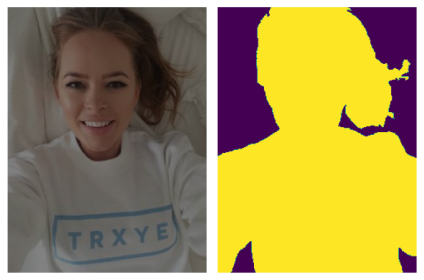

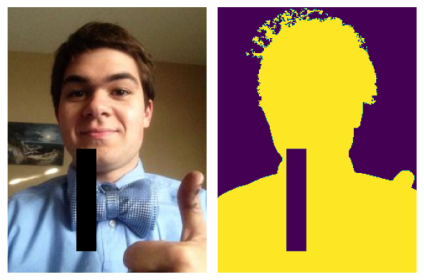

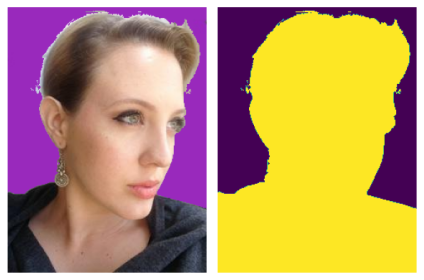

In [8]:
for i in range(3):
    show_idx_image(train_dataset, i)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$. 

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [9]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=0)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [10]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)
        
        if self.with_logits:
            # your code here
            logits = torch.nn.functional.sigmoid(logits)
            # your code here
        
        # your code here
        intersection = torch.sum(logits * true_labels, dim=(-1, -2))
        union = torch.sum(logits, dim=(-1, -2)) + torch.sum(true_labels, dim=(-1, -2))
        dice_coefficient = 2 * intersection / (union + self.eps)
        dice_loss = 1 - dice_coefficient
        # your code here
        
        if self.reduction == 'sum':
            # your code here
            loss_value = torch.sum(dice_loss)
        elif self.reduction == 'mean':
            # your code here
            loss_value = torch.mean(dice_loss)
        elif self.reduction is None:
            # your code here
            loss_value = dice_loss
            
        return loss_value

Проверка реализации:

In [11]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

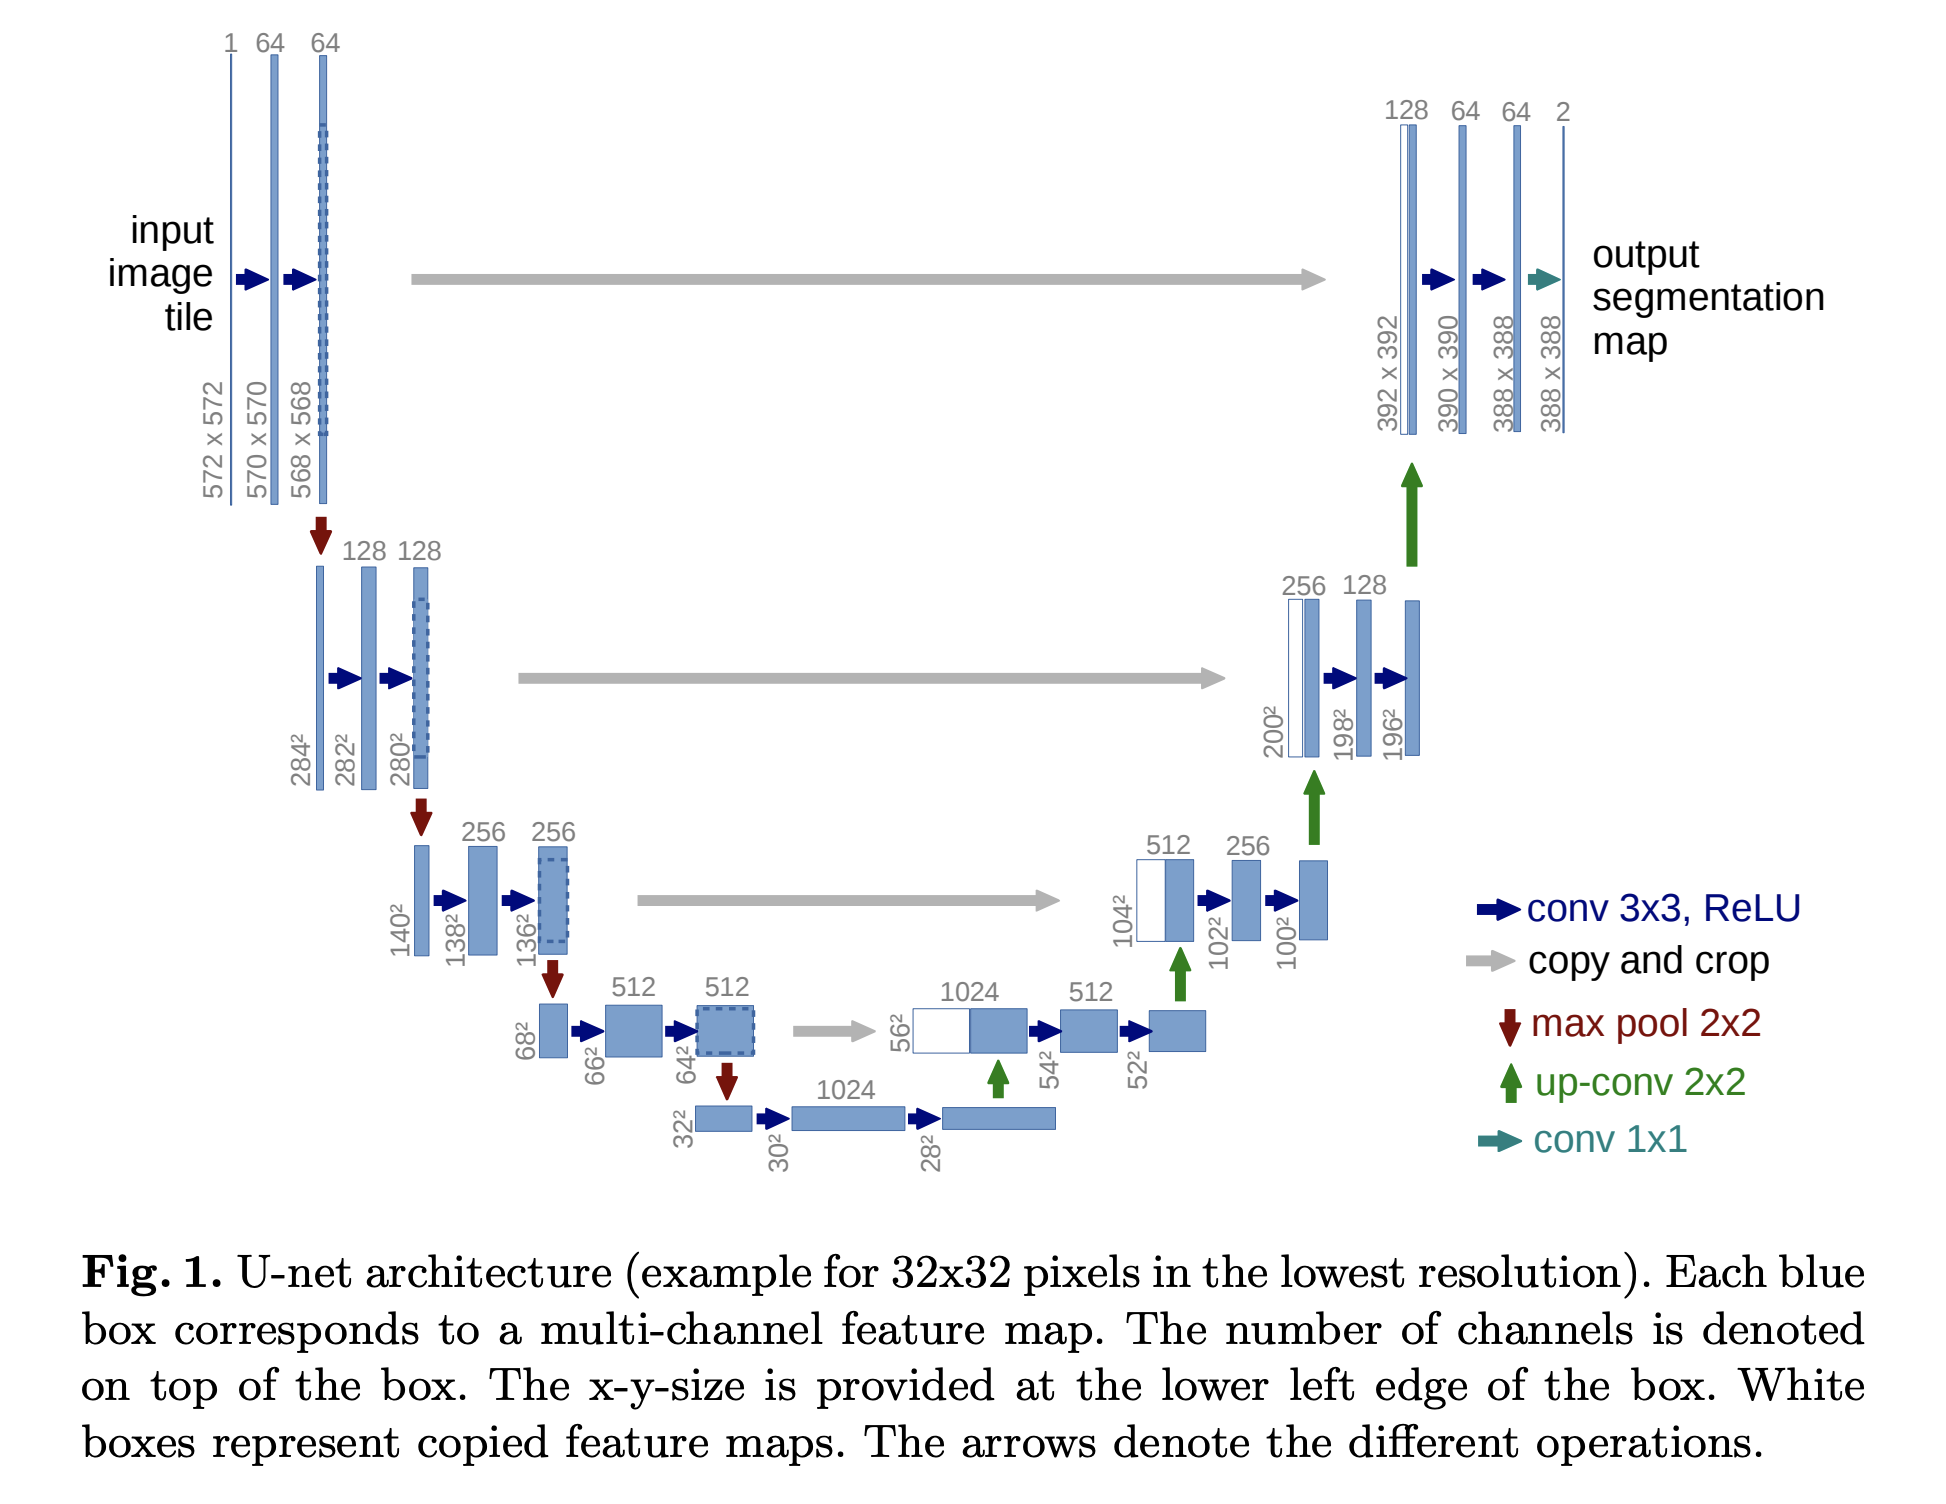

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [12]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        
        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features
        
        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()
        for idx in range(self.num_blocks):
            # Возьмите нужные слои из `feature_extractor` для очередного U-Net блока
            # Объедините их с помощью `torch.nn.Sequential`
            self.blocks.append(
                # your code here
                torch.nn.Sequential(*list(feature_extractor[idx*5:idx*5+4]))
                # your code here
            )

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            # your code here
            x = block(x)

            # Сохраните активации для передачи их в декодер
            # your code here
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            # your code here
            x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
            
        return activations

In [13]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:03<00:00, 173MB/s]  


#### `Decoder`

In [14]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        # your code here
        up = self.upconv(torch.nn.functional.interpolate(down, scale_factor=2))
        
        # Конкатенация выхода энкодера и предыдущего блока декодера
        # your code here
        x = torch.cat([up, left], dim=1)
        
        # Две свёртки с ReLu
        # your code here
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        return x

In [15]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [16]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks).to(device)
        
        # your code here
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1).to(device)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = torch.nn.Conv2d(64, num_classes, kernel_size=1).to(device)

    def forward(self, x):
        # your code here
        x = self.final(self.decoder(self.encoder(x)))

        return x
    
    def named_activations(self):
        activations = []
        for name, module in self.encoder.named_children():
            if isinstance(module, torch.nn.ReLU):
                activations.append((name, module))
        for name, module in self.decoder.named_children():
            if isinstance(module, torch.nn.ReLU):
                activations.append((name, module))
        return activations

In [17]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x.to(device)).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

In [18]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        
        self.threshold = threshold
        self.reduction = reduction
        
    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        # your code here
        predicted_labels = (logits > self.threshold).float()
        intersection = torch.sum(predicted_labels * true_labels, dim=(-1, -2))
        union = torch.sum(predicted_labels, dim=(-1, -2)) + torch.sum(true_labels, dim=(-1, -2)) - intersection
        score = intersection / (union + 1e-5)

        
        if self.reduction == 'sum':
            # your code here
            score = torch.sum(score)
        elif self.reduction == 'mean':
            # your code here
            score = torch.mean(score)
            
        return score

In [19]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Tensorboard и логирование`

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска. 

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной [фигуре](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. [Гиперпараметры модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams) 
5. [Структуру модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph)

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. [Распределение весов, активаций, градиентов](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи. 
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook) (данный хук не работает с inplace операциями, например, с `torch.nn.ReLU(inplace=True)`. Или не используйте inplace операции, или используйте [`Tensor.register_hook`](https://github.com/pytorch/pytorch/issues/61519)), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

Изображения не были выведены, всё есть в архиве

In [20]:
from IPython.display import display
def plot(images, masks, outputs, epoch, writer, loss, metric, loss_name, title):
    fig, axes = plt.subplots(len(images), 4, figsize=(9, 3 * len(images)))

    for i in range(len(images)):
        image = (images[i].cpu().permute(1, 2, 0) * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(masks[i].cpu().squeeze())
        axes[i, 1].set_title('Original')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(outputs[i].detach().cpu().squeeze(), cmap='jet')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
        axes[i, 3].imshow((outputs[i].detach().cpu().squeeze() > 0).cpu().numpy())
        axes[i, 3].set_title(f'Binary prediction\n{loss_name}: {loss[i]:.4f}; IoU: {metric[i]:.4f}')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    writer.add_figure(title, fig, epoch)
    return fig

In [21]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
    metric
):
    list_data = [], [], [], [], [], []
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # send data to device
        len_data = len(images), len(train_loader.dataset)
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        mt = metric(logits, labels).item()
        gn = torch.Tensor([0.0]).to(device)
        wn = torch.Tensor([0.0]).to(device)
        with torch.no_grad():
            for param in model.parameters():
                gn += torch.norm(param.grad) ** 2 if param.grad is not None else 0.0
                wn += torch.norm(param.data) ** 2
        gn = gn.item() ** 0.5
        wn = wn.item() ** 0.5

        list_data[0].append(loss.item())
        list_data[1].append(mt)
        list_data[2].append(wn)
        list_data[3].append(gn)
    list_data[4].append(logits[0])
    return list_data

In [22]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
    metric
):
    val_loss = 0
    val_metric = 0

    network.eval()  # switch network submodules to test mode
    len_ = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels).item()
        val_metric += metric(logits, labels).item()
        len_ += 1

    val_loss /= len_
    val_metric /= len_

    return [val_loss, val_metric]

In [23]:
acts = {}
grads = {}

def activation_hook(module, input, output):
    activations = output[0]
    x = activations
    if len(activations.shape) == 3:
        x = activations.unsqueeze(0)
    acts[module] = x[:1,:3,:,:]

def gradient_hook(module, grad_input, grad_output):
    gradient = grad_output[0]
    x = gradient
    if len(gradient.shape) == 3:
        x = gradient.unsqueeze(0)
    grads[module] = x[:1,:3,:,:]

In [32]:
import time
from torch.utils.tensorboard import SummaryWriter
def train_val(
    network,
    n_epochs,
    criterion,
    name_criterion,
    metric,
    optimizer,
    train_loader,
    val_loader,
    lr_scheduler,
    hparams,
    name_
):
    writer = SummaryWriter()
    loss_ = []
    metric_ = []
    best_ac = 0
    loss_sum = 0
    metric_sum = 0
    network.eval()
    len_ = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        loss_sum += criterion(logits, labels).item()
        metric_sum += metric(logits, labels).item()
        len_ += 1
    writer.add_scalar(f'Train {name_criterion}', loss_sum / len_, 0)
    loss_.append(loss_sum / len_)
    if name_criterion == 'DiceLoss':
        writer.add_scalar('Train DiceCoefficient', 1 - loss_sum / len_, 0)
    writer.add_scalar('Train IoU', metric_sum / len_, 0)
    metric_.append(metric_sum / len_)
    network.train()

    val_res = val_epoch(network, val_loader, criterion, metric)
    writer.add_scalar(f'Test {name_criterion}', val_res[0], 0)
    if name_criterion == 'DiceLoss':
        writer.add_scalar('Test DiceCoefficient', 1 - val_res[0], 0)
    writer.add_scalar('Test IoU', val_res[1], 0)

    batch = 0
    for epoch in range(1, n_epochs + 1):
        print(epoch)
        list_data = train_epoch(network, train_loader, criterion, optimizer, metric)
        val_res = val_epoch(network, val_loader, criterion, metric)
        lr_scheduler.step(val_res[0])
        if val_res[1] > best_ac:
            best_ac = val_res[1]
            torch.save(network.state_dict(), f'model_{name_}.pth')
            torch.save(optimizer.state_dict(), f'optimizer_{name_}.pth')
        
        writer.add_scalar(f'Test {name_criterion}', val_res[0], epoch)
        if name_criterion == 'DiceLoss':
            writer.add_scalar('Test DiceCoefficient', 1 - val_res[0], epoch)
        writer.add_scalar('Test IoU', val_res[1], epoch)
        
        for j in range(len(list_data[0])):
            batch += 1
            writer.add_scalar(f'Train {name_criterion}', list_data[0][j], batch)
            loss_.append(list_data[0][j])
            if name_criterion == 'DiceLoss':
                writer.add_scalar('Train DiceCoefficient', 1 - list_data[0][j], batch)
            writer.add_scalar('Train IoU', list_data[1][j], batch)
            metric_.append(list_data[1][j])
            writer.add_scalar('Train wn', list_data[2][j], batch)
            writer.add_scalar('Train gn', list_data[3][j], batch)
        
        hooks = []
        for name, module in network.named_modules():
            if not list(module.parameters()):
                continue
            hook_activation = module.register_forward_hook(activation_hook)
            hook_gradient = module.register_backward_hook(gradient_hook)
            hooks.append(hook_activation)
            hooks.append(hook_gradient)
            for name, param in module.named_parameters():
                if 'weight' in name:
                    writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
                if param.grad is not None:
                    if 'weight' in name:
                        writer.add_histogram(name + '_grad', param.grad.clone().cpu().data.numpy(), epoch)
        
        for name, activation in network.named_activations():
            writer.add_histogram(name, activation.clone().cpu().data.numpy(), epoch)
        
        i = 0
        for images, labels in val_loader:
            if i != 0:
                continue
            i += 1
            images, labels = images.to(device), labels.to(device)
            logits1 = network(images[:1])
            logits2 = network(images[1:2])
            logits3 = network(images[2:3])
            val_loss1 = criterion(logits1, labels[:1]).item()
            val_metric1 = metric(logits1, labels[:1]).item()
            val_loss2 = criterion(logits2, labels[1:2]).item()
            val_metric2 = metric(logits2, labels[1:2]).item()
            val_loss3 = criterion(logits3, labels[2:3]).item()
            val_metric3 = metric(logits3, labels[2:3]).item()
            fig = plot(images[:3], labels[:3], [logits1, logits2, logits3], epoch, writer, [val_loss1, val_loss2, val_loss3], [val_metric1, val_metric2, val_metric3], name_criterion, 'Test')
            #display(fig)
        
        for name, activation in acts.items():
            writer.add_images(f'Activations/{name.__class__.__name__}', activation, epoch)

        for name, gradient in grads.items():
            writer.add_images(f'Gradient/{name.__class__.__name__}', gradient, epoch)
        
        for hook in hooks:
            hook.remove()

        writer.flush()

    writer.add_hparams(hparams, {'IoU': best_ac})
    writer.add_graph(network.to(device), torch.randn(1, 3, 224, 224).to(device))
    writer.flush()
    writer.close()
    return torch.load(f'model_{name_}.pth'), torch.load(f'optimizer_{name_}.pth'), loss_, metric_

Количество эпох было взято небольшим в силу ограниченности времени и ресурсов для вычислений (сдача с просроком обусловлена этим же)

In [ ]:
model = UNet(num_blocks=4, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'UNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 20,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'DiceLoss'
}

res = train_val(
    network=model,
    n_epochs=20,
    criterion=DiceLoss(reduction='mean').to(device),
    name_criterion='DiceLoss',
    metric=IoUScore(0.0, reduction='mean').to(device),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=1
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='DiceLoss')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()


1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1334: UserWarning: Using non-full backward hooks on

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [35]:
model = UNet(num_blocks=4, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'UNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 20,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'BCEWithLogitsLoss'
}

res = train_val(
    network=model,
    n_epochs=20,
    criterion=torch.nn.BCEWithLogitsLoss().to(device),
    name_criterion='BCEWithLogitsLoss',
    metric=IoUScore(0.0, reduction='mean'),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=2
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='BCEWithLogitsLoss')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()

1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1334: UserWarning: Using non-full backward hooks on

2


KeyboardInterrupt: 

In [ ]:
Ячейка выше была случайно запущена заново и прервана

In [36]:
def adaptive_loss_1(outputs, masks):
    bce = torch.nn.BCEWithLogitsLoss().to(device)
    dice = DiceLoss(reduction='mean').to(device)
    return 0.25 * bce(outputs, masks) + 0.75 * dice(outputs, masks)

def adaptive_loss_2(outputs, masks):
    bce = torch.nn.BCEWithLogitsLoss().to(device)
    dice = DiceLoss(reduction='mean').to(device)
    return 0.5 * bce(outputs, masks) + 0.5 * dice(outputs, masks)

def adaptive_loss_3(outputs, masks):
    bce = torch.nn.BCEWithLogitsLoss().to(device)
    dice = DiceLoss(reduction='mean').to(device)
    return 0.75 * bce(outputs, masks) + 0.25 * dice(outputs, masks)

1
2
3
4
5
6
7
8
9
10


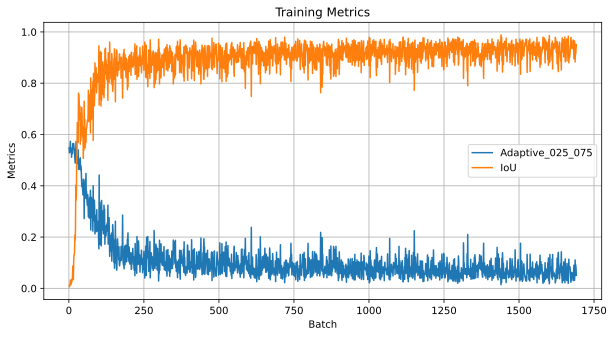

In [37]:
model = UNet(num_blocks=4, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'UNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 10,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'Adaptive_025_075'
}

res = train_val(
    network=model,
    n_epochs=10,
    criterion=adaptive_loss_1,
    name_criterion='Adaptive_025_075',
    metric=IoUScore(0.0, reduction='mean'),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=3
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='Adaptive_025_075')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()

1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1334: UserWarning: Using non-full backward hooks on

2
3
4
5
6
7
8
9
10


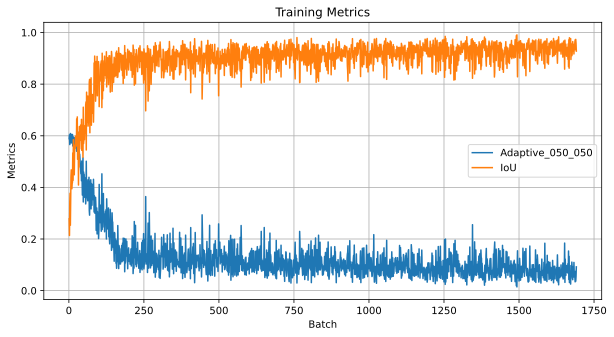

In [40]:
model = UNet(num_blocks=4, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'UNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 10,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'Adaptive_050_050'
}

res = train_val(
    network=model,
    n_epochs=10,
    criterion=adaptive_loss_2,
    name_criterion='Adaptive_050_050',
    metric=IoUScore(0.0, reduction='mean'),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=4
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='Adaptive_050_050')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()

1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1334: UserWarning: Using non-full backward hooks on

2
3
4
5
6
7
8
9
10


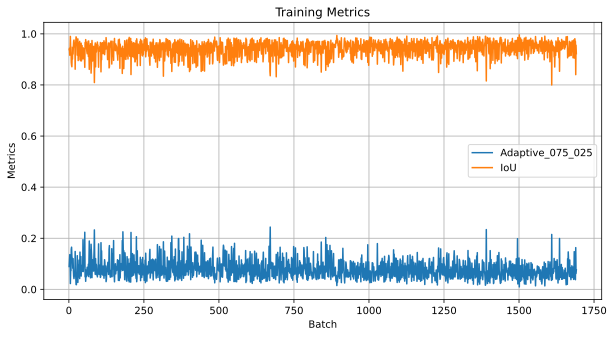

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'UNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 10,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'Adaptive_075_025'
}

res = train_val(
    network=model,
    n_epochs=10,
    criterion=adaptive_loss_3,
    name_criterion='Adaptive_075_025',
    metric=IoUScore(0.0, reduction='mean'),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=5
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='Adaptive_075_025')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()

В ячейке выше нечаянно не сбросил модель( Вывод общий в конце работы

## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [42]:
class LinkNetDecoderBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upconv = torch.nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, x, sc):
        up = self.upconv(x)
        x = up[:, :, :sc.size(2), :sc.size(3)]  + sc
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=2, num_blocks=3):
        super().__init__()
        # your code here
        self.num_blocks = num_blocks
        self.encoder = VGG13Encoder(num_blocks).to(device)

        # your code here
        self.decoder = torch.nn.ModuleList()
        for i in range(num_blocks - 1, 0, -1):
            self.decoder.append(LinkNetDecoderBlock(64 * 2 ** i, 64 * 2 ** (i - 1)))

        # your code here
        self.final = torch.nn.Conv2d(64, num_classes, kernel_size=1).to(device)

    def forward(self, x):
        encod = self.encoder(x)
        x = encod[-1]
        for block, sc in zip(self.decoder, encod[-2::-1]):
            x = block(x, sc)
        x = self.final(x)
        return x
    
    def named_activations(self):
        activations = []
        for name, module in self.encoder.named_children():
            if isinstance(module, torch.nn.ReLU):
                activations.append((name, module))
        for name, module in self.decoder.named_children():
            if isinstance(module, torch.nn.ReLU):
                activations.append((name, module))
        return activations

1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


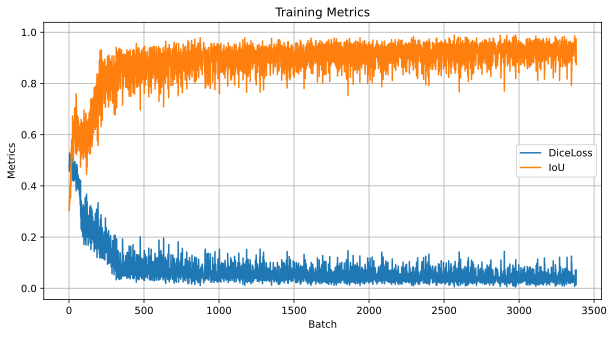

In [43]:
model = LinkNet(num_blocks=4, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'LinkNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 20,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'DiceLoss'
}

res = train_val(
    network=model,
    n_epochs=20,
    criterion=DiceLoss(reduction='mean').to(device),
    name_criterion='DiceLoss',
    metric=IoUScore(0.0, reduction='mean').to(device),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=6
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='DiceLoss')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()


1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


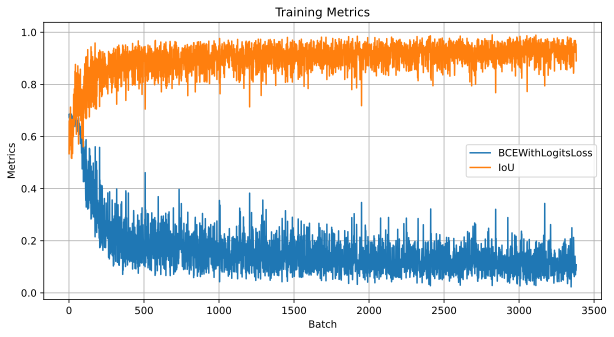

In [ ]:
model = LinkNet(num_blocks=4, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'LinkNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 20,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'BCEWithLogitsLoss'
}

res = train_val(
    network=model,
    n_epochs=20,
    criterion=torch.nn.BCEWithLogitsLoss().to(device),
    name_criterion='BCEWithLogitsLoss',
    metric=IoUScore(0.0, reduction='mean'),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=7
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='BCEWithLogitsLoss')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()

1
2
3
4
5
6
7
8
9
10


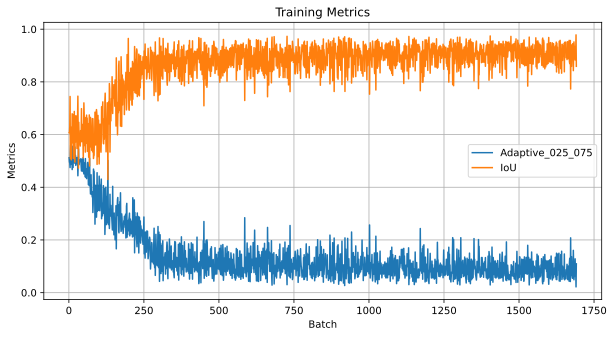

In [46]:
model = LinkNet(num_blocks=4, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'LinkNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 10,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'Adaptive_025_075'
}

res = train_val(
    network=model,
    n_epochs=10,
    criterion=adaptive_loss_1,
    name_criterion='Adaptive_025_075',
    metric=IoUScore(0.0, reduction='mean'),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=8
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='Adaptive_025_075')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()

1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "


2
3
4
5
6
7
8
9
10


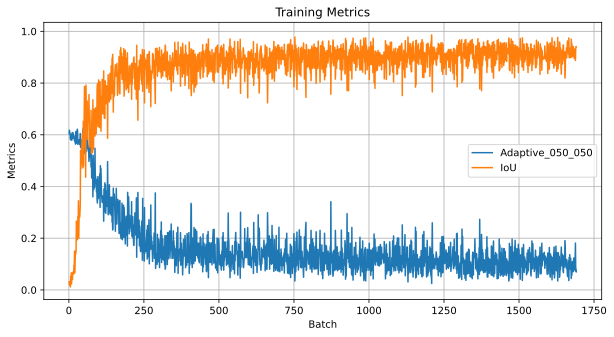

In [47]:
model = LinkNet(num_blocks=4, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'LinkNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 10,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'Adaptive_050_050'
}

res = train_val(
    network=model,
    n_epochs=10,
    criterion=adaptive_loss_2,
    name_criterion='Adaptive_050_050',
    metric=IoUScore(0.0, reduction='mean'),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=9
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='Adaptive_050_050')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()

1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "


2
3
4
5
6
7
8
9
10


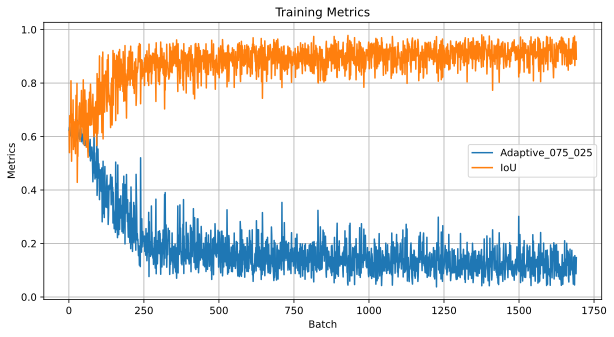

In [48]:
model = LinkNet(num_blocks=4, num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

hparams = {
    'model_name': 'LinkNet',
    'num_classes': 1,
    'num_blocks': 4,
    'num_epochs': 10,
    'lr': 1e-5,
    'lr_scheduler': 'ReduceLROnPlateau',
    'optimizer': 'Adam',
    'loss_function': 'Adaptive_075_025'
}

res = train_val(
    network=model,
    n_epochs=10,
    criterion=adaptive_loss_3,
    name_criterion='Adaptive_075_025',
    metric=IoUScore(0.0, reduction='mean'),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    lr_scheduler=lr_scheduler,
    hparams=hparams,
    name_=10
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(res[2]) + 1), res[2], label='Adaptive_075_025')
plt.plot(range(1, len(res[3]) + 1), res[3], label='IoU')
plt.xlabel('Batch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training Metrics')
plt.grid()
plt.show()

1. Выводы по экспериментам с Unet. В качестве метрики качества рассматривается UoI. Лучшее качество было достигнуто с кросс-энтропией ВСЕ. Однако с DiceLoss качество также на высоком уровне (больше 0.9). Для BCE свойственно относить к объекту меньшее количество пикселей, чем то количество, из которых он состоит на самом деле. Для первой важнее точность, для второй полнота. Это наблюдение (относительно площадей объектов и предсказаний) можно выгодно использовать, если заранее анализировать формы сегментируемых объектов (аналогия с эрозией и дилатацией). Проанализировав результаты, полученные с помощью моделей, использующих при обучении комбинации функций потерь, можно сделать вывод, что чем больше вклад BCE в комбинацию, тем выше качество (пусть и на очень малую величину).

2. Выводы по экспериментам с LinkNet и сравнение с UNet. Качество по метрике IoU для всех функций потерь и их комбинаций аналогично предыдущим экспериментам хуже (на 1,5 - 2,5 %), чем для Unet, причем сравнивая результаты только для Unet (для разных функций потерь и комбинаций) и LinkNet, можно наблюдать аналогичные закономерности.  Unet имеет большее количество параметров, а поэтому такая сеть сложнее. Однако из этого соображения следует, что время обучения для LinkNet нужно меньше. Выбор между этими архитектурами на практике, вероятно, зависит от приоритета качества и скорости обучения.

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

Предположения о структуре входных данных:

1. Локальность. Cигналы в данных имеют локальную зависимость, что означает, что информация близко расположенных элементов в данных часто связана. Например, в изображениях соседние пиксели имеют тесную корреляцию.

2. Стационарность. Предполагается, что статистические свойства данных не меняются в разных областях входного пространства. Это означает, что характеристики данных остаются постоянными в разных частях изображения или других типов входных данных.

3. Иерархическая организация. Данные имеют иерархическую структуру, где более высокие уровни абстракции строятся на основе низкоуровневых признаков. Например, в изображениях низкоуровневые признаки, такие как грани и текстуры, используются для формирования более высокоуровневых признаков, таких как формы и объекты.

Преимущества использования сверток:

1. Параметрическая эффективность. Сверточные сети используют общие веса ядер свертки, что значительно сокращает количество параметров по сравнению с полносвязными сетями. Это уменьшает риск переобучения и позволяет эффективнее обучать модели на небольших наборах данных.

2. Иерархическое извлечение признаков. Сверточные слои позволяют автоматически извлекать признаки на разных уровнях абстракции, начиная с простых признаков, таких как грани и углы, и заканчивая более сложными паттернами и объектами. Это позволяет моделям эффективно решать задачи распознавания и классификации.

3. Инвариантность к переводу и масштабу: Сверточные операции обеспечивают инвариантность к переводу и небольшим изменениям в масштабе, что делает их эффективными для анализа объектов в разных частях изображений и различных масштабах.

Пример входных данных, когда предположения не выполняются:

1. Видео с быстро меняющимися сценами, где объекты перемещаются или изменяются внешним видом слишком быстро для того, чтобы сохранить стационарность.
2. Временные ряды, где зависимости между данными не локальны (например, долгосрочные зависимости), или когда статистические свойства данных меняются в разных областях (например, в аудиофайлах звуки могут изменяться со временем).


### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

Для полносвязного слоя ${f(\cdot)}$:

1. Размерность выходного пространства. Размерность выходного пространства будет ${1000}$, так как матрица весов ${W}$ имеет размерность ${1000\times 100}$.

2. Количество обучаемых параметров. Количество обучаемых параметров равно количеству элементов в матрице весов ${W}$, то есть ${1000 \times 100 = 100000}$.

3. Число операций при выполнении forward pass. Для вычисления выхода ${f(x^{(i)})}$ с использованием наивной реализации перемножения матриц необходимо выполнить ${1000 \times 100}$ умножений и ${1000 \times 99}$ сложений, что дает общее количество операций равное ${1000 \times (100 + 99) = 199000}$. Применение сигмоиды даёт еще 1000 операций.

Для сверточного слоя ${g(\cdot)}$:

1. Размерность выходного пространства. Размерность выходного пространства за счёт карт признаков равна ${100 \times 10 = 1000}$.

2. Количество обучаемых параметров. Количество обучаемых параметров зависит от числа карт признаков и размера ядра свертки. В данном случае у нас есть 10 карт признаков и каждая сверточная карта связана с ядром свертки размером ${3}$. Таким образом, общее количество обучаемых параметров будет ${10 \times 3 = 30}$.

3. Число операций при выполнении forward pass. При наивной реализации сверток необходимо выполнить ${10 \times (100 \times 3 + 100 \times 2) = 5000}$ операций, где ${100}$ - размер входного пространства, ${10}$ - количество карт признаков, ${3}$ - размер ядра свертки.

In [49]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/model_1.pth (deflated 8%)
  adding: kaggle/working/optimizer_2.pth (deflated 7%)
  adding: kaggle/working/model_5.pth (deflated 8%)
  adding: kaggle/working/model_9.pth (deflated 8%)
  adding: kaggle/working/model_2.pth (deflated 8%)
  adding: kaggle/working/optimizer1.pth (deflated 8%)
  adding: kaggle/working/optimizer_6.pth (deflated 7%)
  adding: kaggle/working/optimizer_9.pth (deflated 7%)
  adding: kaggle/working/optimizer_5.pth (deflated 8%)
  adding: kaggle/working/model_4.pth (deflated 8%)
  adding: kaggle/working/optimizer_1.pth (deflated 8%)
  adding: kaggle/working/optimizer_8.pth (deflated 7%)
  adding: kaggle/working/model_6.pth (deflated 8%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/optimizer_7.pth (deflated 7%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/Mar30_18-35-17_656b80499da0/ (stored 0%)
  adding: kaggle/working/runs/Mar30_18-35-17_6

In [50]:
!ls

file.zip      model_4.pth  model_9.pth	     optimizer_3.pth  optimizer_8.pth
model_1.pth   model_5.pth  optimizer1.pth    optimizer_4.pth  optimizer_9.pth
model_10.pth  model_6.pth  optimizer_1.pth   optimizer_5.pth  runs
model_2.pth   model_7.pth  optimizer_10.pth  optimizer_6.pth
model_3.pth   model_8.pth  optimizer_2.pth   optimizer_7.pth


In [51]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [55]:
from IPython.display import FileLink
FileLink(r'model_1.pth')

/kaggle/working/model_1.pth

In [58]:
FileLink(r'model_2.pth')

/kaggle/working/model_2.pth

In [59]:
FileLink(r'model_3.pth')

/kaggle/working/model_3.pth

In [60]:
FileLink(r'model_4.pth')

/kaggle/working/model_4.pth

In [61]:
FileLink(r'model_5.pth')

/kaggle/working/model_5.pth

In [62]:
FileLink(r'model_6.pth')

/kaggle/working/model_6.pth

In [63]:
FileLink(r'model_7.pth')

/kaggle/working/model_7.pth

In [64]:
FileLink(r'model_8.pth')

/kaggle/working/model_8.pth

In [65]:
FileLink(r'model_9.pth')

/kaggle/working/model_9.pth

In [66]:
FileLink(r'model_10.pth')

/kaggle/working/model_10.pth

In [67]:
FileLink(r'optimizer_1.pth')

/kaggle/working/optimizer_1.pth

In [68]:
FileLink(r'optimizer_2.pth')

/kaggle/working/optimizer_2.pth

In [69]:
FileLink(r'optimizer_3.pth')

/kaggle/working/optimizer_3.pth

In [70]:
FileLink(r'optimizer_4.pth')

/kaggle/working/optimizer_4.pth

In [71]:
FileLink(r'optimizer_5.pth')

/kaggle/working/optimizer_5.pth

In [72]:
FileLink(r'optimizer_6.pth')

/kaggle/working/optimizer_6.pth

In [73]:
FileLink(r'optimizer_7.pth')

/kaggle/working/optimizer_7.pth

In [74]:
FileLink(r'optimizer_8.pth')

/kaggle/working/optimizer_8.pth

In [75]:
FileLink(r'optimizer_9.pth')

/kaggle/working/optimizer_9.pth

In [76]:
FileLink(r'optimizer_10.pth')

/kaggle/working/optimizer_10.pth

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

In [ ]:
Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```